# Wetterstation Kloten

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
from scipy import integrate
from scipy import optimize

## 1. Import der Daten

### Datenimport und Datenvorbereitung
1. Zuerst werden die Wetterdaten aus der CSV-Datei "`Daten/Zürich21-22.csv`" importiert. Diese enthält die Informationen für verschiedene Wetterstationen in Zürich.
2. Danach werden die Daten von Kloten aus den Gesamtendaten von Zürich herausgefiltert.
3. Des Weitern werden die Wetterdaten transponiert, um die Zeilen in Spalten umzuwandeln, damit die Daten leichter zu bearbeiten sind. 
4. In einem letzen Schritt werden die Wetterparameter *(Luftdruck, Temperatur, Niederschlagsmenge und Sonnenstunden)* von den transponierten Daten extrahiert, in einen geeigneten Datentypen umgewandelt und als separate *Arrays* abgpeichert.

In [2]:
#CSV-Datei laden
weather = np.loadtxt('Daten/Zürich21-22.csv', skiprows=1, delimiter=';', dtype=str)

#Daten nach KLO filtern
klo_weather = weather[weather[:, 0] == 'KLO']

In [3]:
#Daten transponieren
klo_weather_t = np.transpose(klo_weather)

#Arrays für die Daten bereitstellen
time        = klo_weather_t[1].astype("datetime64[m]").astype(float) #Zeit im Minutenintervall als float dargestellt
pressure    = klo_weather_t[2].astype(float)
temp        = klo_weather_t[3].astype(float)
rain        = klo_weather_t[4].astype(float)
sunshine    = klo_weather_t[5].astype(float)
time_diff   = klo_weather_t[6].astype(float)

### Beschreibung der Daten
- #stn: Wetterstation
- time: Zeitpunkt der Messung
- prestah0: Luftdruck [hPa]
- tre200h0: Lufttemperatur [°C]
- rre150h0: Niederschlagssumme [mm]
- su2000h0: Sonnenscheindauer [%]
- time_diff: Stunden seit Messbeginn [h]

### Anzahl Messungen

In [4]:
print("Anzahl Messungen:", len(klo_weather))

Anzahl Messungen: 7473


## 2. Da einige Datenpunkte fehlen, müsst ihr diese interpolieren.

### Daten Interpolieren

1. Mit der NumPy-Funktion `linspace` wird ein Zeitvektors mit zusätzlichen Zwischenpunkten erzeugt.
2. Um die Lücken in den ursprünglichen Messdaten auszugleichen werden die Daten mit `scipy.interpolate.interp1d` interpoliert.
3. Danach werden die Wetterdaten von Kloten visualisiert.

In [5]:
# Maximaler Zeitunterschied bestimmen, um die Anzahl Datenpunkte für die Interpolation zu bestimmen
max = int(np.max(time_diff))

#Erzeugen des Zeitvektors mit den fehlenden Stunden und Intervall auf Halbstundenbasis verkürzen
time_new = np.linspace(time.min(), time.max(), ((2*max)+1), dtype=int) 

#Daten kubische und linear interpolieren
f_cubic     = interp1d(time, klo_weather_t[2:6], kind='cubic')
f_linear    = interp1d(time, klo_weather_t[2:6], kind = 'linear')

#Die interpolierten Werte für Druck, Temperatur, Niederschlag und Sonnenschein werden in separaten Variablen für jede Interpolationsmethode gespeichert.
pressure_inter_cubic, temp_inter_cubic, rain_inter_cubic, sunshine_inter_cubic       = f_cubic(time_new)
pressure_inter_linear, temp_inter_linear, rain_inter_linear, sunshine_inter_linear   = f_linear(time_new)

#time zu datetime umwandeln für spätere Darstellungszwecke
time_datetime = time.astype("datetime64[m]")
time_datetime_inter = time_new.astype("datetime64[m]")

In [31]:
print(max)
print(len(time_new))

8783
17567


Bemerkungen:
- Durch die Verwendung des maximalen Zeitunterschieds als Endpunkt des Zeitvektors wird sichergestellt, dass der gesamte Zeitbereich abgedeckt wird.
- Der Zeitvektor `time_new` reicht von 0 bis zu `max`. aber hat doppelt so viele Werte. Das bedeutet, dass das Zeitintervall zwischen den Messungen halbiert wird und die Anzahl der Daten nach der Interpolation (mehr als) verdoppelt wird (+1).

### Interpolationsmethode vergleichen

Um eine kontinuierliche zeitliche Darstellung der Wetterparameter zu ermöglichen, werden die Wetterdaten von Kloten interpoliert. Hierfür mussten verschiedene Methoden getestet werden, um die beste interpolations Methode für die einzelen Wetterparameter zu finden.

- Lineare Interpolation:
    - approximiert Werte zwischen zwei Messpunkten mit einer Gerade 
    - geeignet für Daten mit erwarteter linearer Beziehung und geringen Schwankungen
- Kubische Interpolation:
    - verwendet kubisches Polynom, um Datenpunkte zu interpolieren
    - erfasst Krümmungen und komplexe Schwankungen besser als lineare Interpolation
    - eignet sich für glatte und kontinuierliche Kurven (zur Schätzung von Zwischenwerten)

In [6]:
#Daten für Demo vorbereiten, damit der Bereich des Plots der Interpolationsdaten schneller geändert werden kann
datetime_demo= time_datetime[:25]
max_demo = 2 * int(np.max(time_diff[:25])) + 1

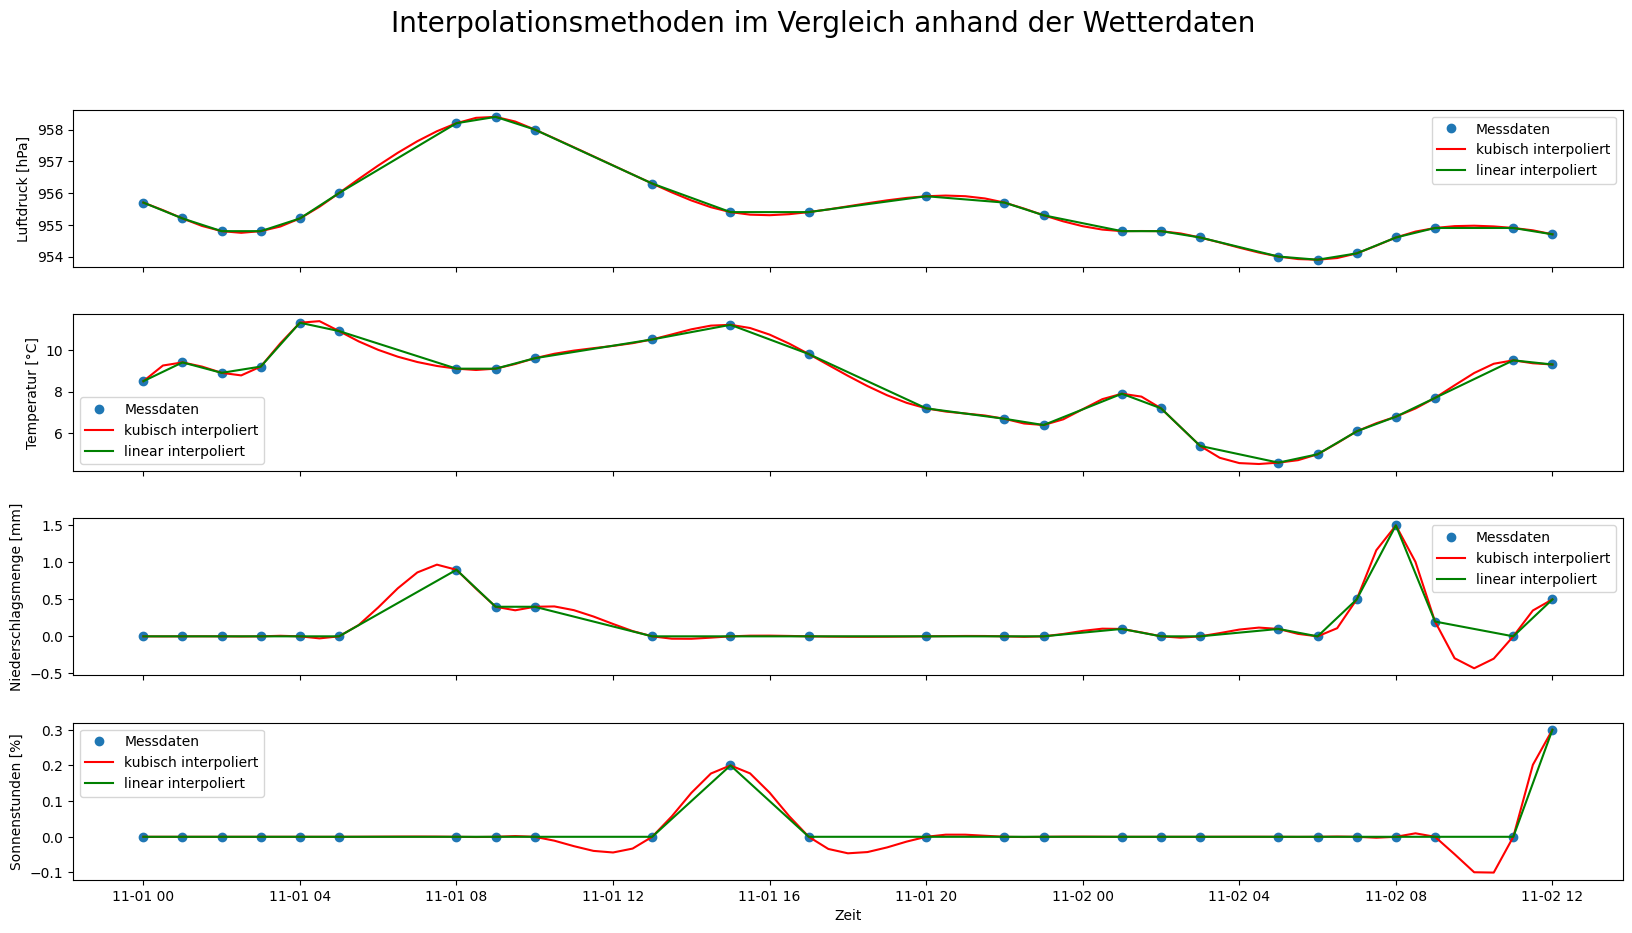

In [7]:
#Plot über einen bestimmten Zeitraum um die Interpolationsmethoden zu vergleichen
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.plot(datetime_demo, pressure[:25], 'o', label='Messdaten')
ax1.plot(time_datetime_inter[0:max_demo], pressure_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax1.plot(time_datetime_inter[0:max_demo], pressure_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax1.set_ylabel('Luftdruck [hPa]')
ax1.legend()

ax2.plot(datetime_demo, temp[:25], 'o', label='Messdaten')
ax2.plot(time_datetime_inter[0:max_demo], temp_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax2.plot(time_datetime_inter[0:max_demo], temp_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax2.set_ylabel('Temperatur [°C]')
ax2.legend()

ax3.plot(datetime_demo, rain[:25], 'o', label='Messdaten')
ax3.plot(time_datetime_inter[0:max_demo], rain_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax3.plot(time_datetime_inter[0:max_demo], rain_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax3.set_ylabel('Niederschlagsmenge [mm]')
ax3.legend()

ax4.plot(datetime_demo, sunshine[:25], 'o', label='Messdaten')
ax4.plot(time_datetime_inter[0:max_demo], sunshine_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax4.plot(time_datetime_inter[0:max_demo], sunshine_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax4.set_ylabel('Sonnenstunden [%]')
ax4.legend()

plt.xlabel('Zeit')
plt.suptitle('Interpolationsmethoden im Vergleich anhand der Wetterdaten', fontsize=20)
plt.show()

### Auswahl der Interpolationsmethoden

Entscheidung: 
- Temperatur und Luftdruck: kubische Interpolation 
- Sonnenstunden und Niederschlagsmenge: lineare Interpolation 

Für die zeitliche Interpolation der Parameter *Temperatur* und *Luftdruck* haben wir die kubische Funktion gewählt. Dies ermöglicht eine präzisere Ermittlung der stündlichen Werte zwischen den Messzeitpunkten im Vergleich zur linearen Funktion. Normalerweise weisen Temperatur- und Luftdruckkurven einen glatten Verlauf auf, ohne scharfe Ecken oder Diskontinuitäten. Die lineare Interpolation konnte die vielen Schwankungen in den Daten nicht genau darstellen.

Die *Sonnenstunden* und *Niederschlagsmengen* wurden hingegen linear interpoliert, da diese Werte nicht unter Null fallen können, was bei der Verwendung der kubischen Funktion passiert ist. In unserem Demo-Plot "`Interpolationsmethoden im Vergleich anhand der Wetterdaten`" ist zu sehen, dass die Daten für Sonnenstunden und Niederschlagsmenge unteranderem auch linear verlaufen können und viel weniger Schwankungen als bei den Temperatur- und den Luftruckdaten aufweisen.

## 3. Ihr sollt alle Variablen (Luftdruck, Temperatur, Regenmenge und Sonnenstunden) über einen selbstgewählten Zeitraum darstellen. 

### Tagesdurschnitt berechnen

1. In einer Schleife wird der Tagesdurchschnitt für jeden Tag berechnet. Die entsprechenden Werte für *Luftdruck, Temperatur, Niederschlag und Sonnenschein* werden summiert, und nach jeweils 48 Messwerten wird der Durchschnitt gebildet und den entsprechenden *Arrays* hinzugefügt. Die Variablen für den Durchschnitt werden danach zurückgesetzt.

In [8]:
#Initalisieren der Variablen, um den Tagesdurschnitt zu berechnen
daily_pressure = np.array([]).astype(float)
daily_average_pressure = 0

daily_temp = np.array([]).astype(float)
daily_average_temp = 0

daily_rain = np.array([]).astype(float)
daily_average_rain = 0

daily_sunshine = np.array([]).astype(float)
daily_average_sun = 0

date = np.array([]).astype(datetime.date)

#für den letzten Tag wird der Durchschnitt nicht gerechnet, da die letzte stunde fehlt und somit wir die Daten für genau ein Jahr haben.
incomplete_hours = len(time_new) % 48

#Tagesdurschnitt berechnen (pro Tag 48 Messwerte)
for i in range(len(time_new) - incomplete_hours):
    daily_average_pressure += pressure_inter_cubic[i]
    daily_average_temp += temp_inter_cubic[i]
    daily_average_rain += rain_inter_linear[i]
    daily_average_sun += sunshine_inter_linear[i]
    if (i+1) % 48 == 0:
        daily_pressure = np.append(daily_pressure, daily_average_pressure/48)
        daily_average_pressure = 0
        daily_temp = np.append(daily_temp, daily_average_temp/48)
        daily_average_temp = 0
        daily_rain = np.append(daily_rain, daily_average_rain/48)
        daily_average_rain = 0
        daily_sunshine = np.append(daily_sunshine, daily_average_sun/48)
        daily_average_sun = 0
        date = np.append(date, time_datetime_inter[i].astype(datetime.datetime).date())



Bemerkung:

Die Anzahl der unvollständigen Stunden `incomplete_hours` wird berechnet, weil wir gemerkt haben, dass der letzte Tag in den Messwerten nicht komplett ist (letzte halbestunde fehlt). Die `incomplete_hours`  können wir aus der Schleife abziehen, und kommen so genau auf Messdaten in einem Zeitraum von einem Jahr.

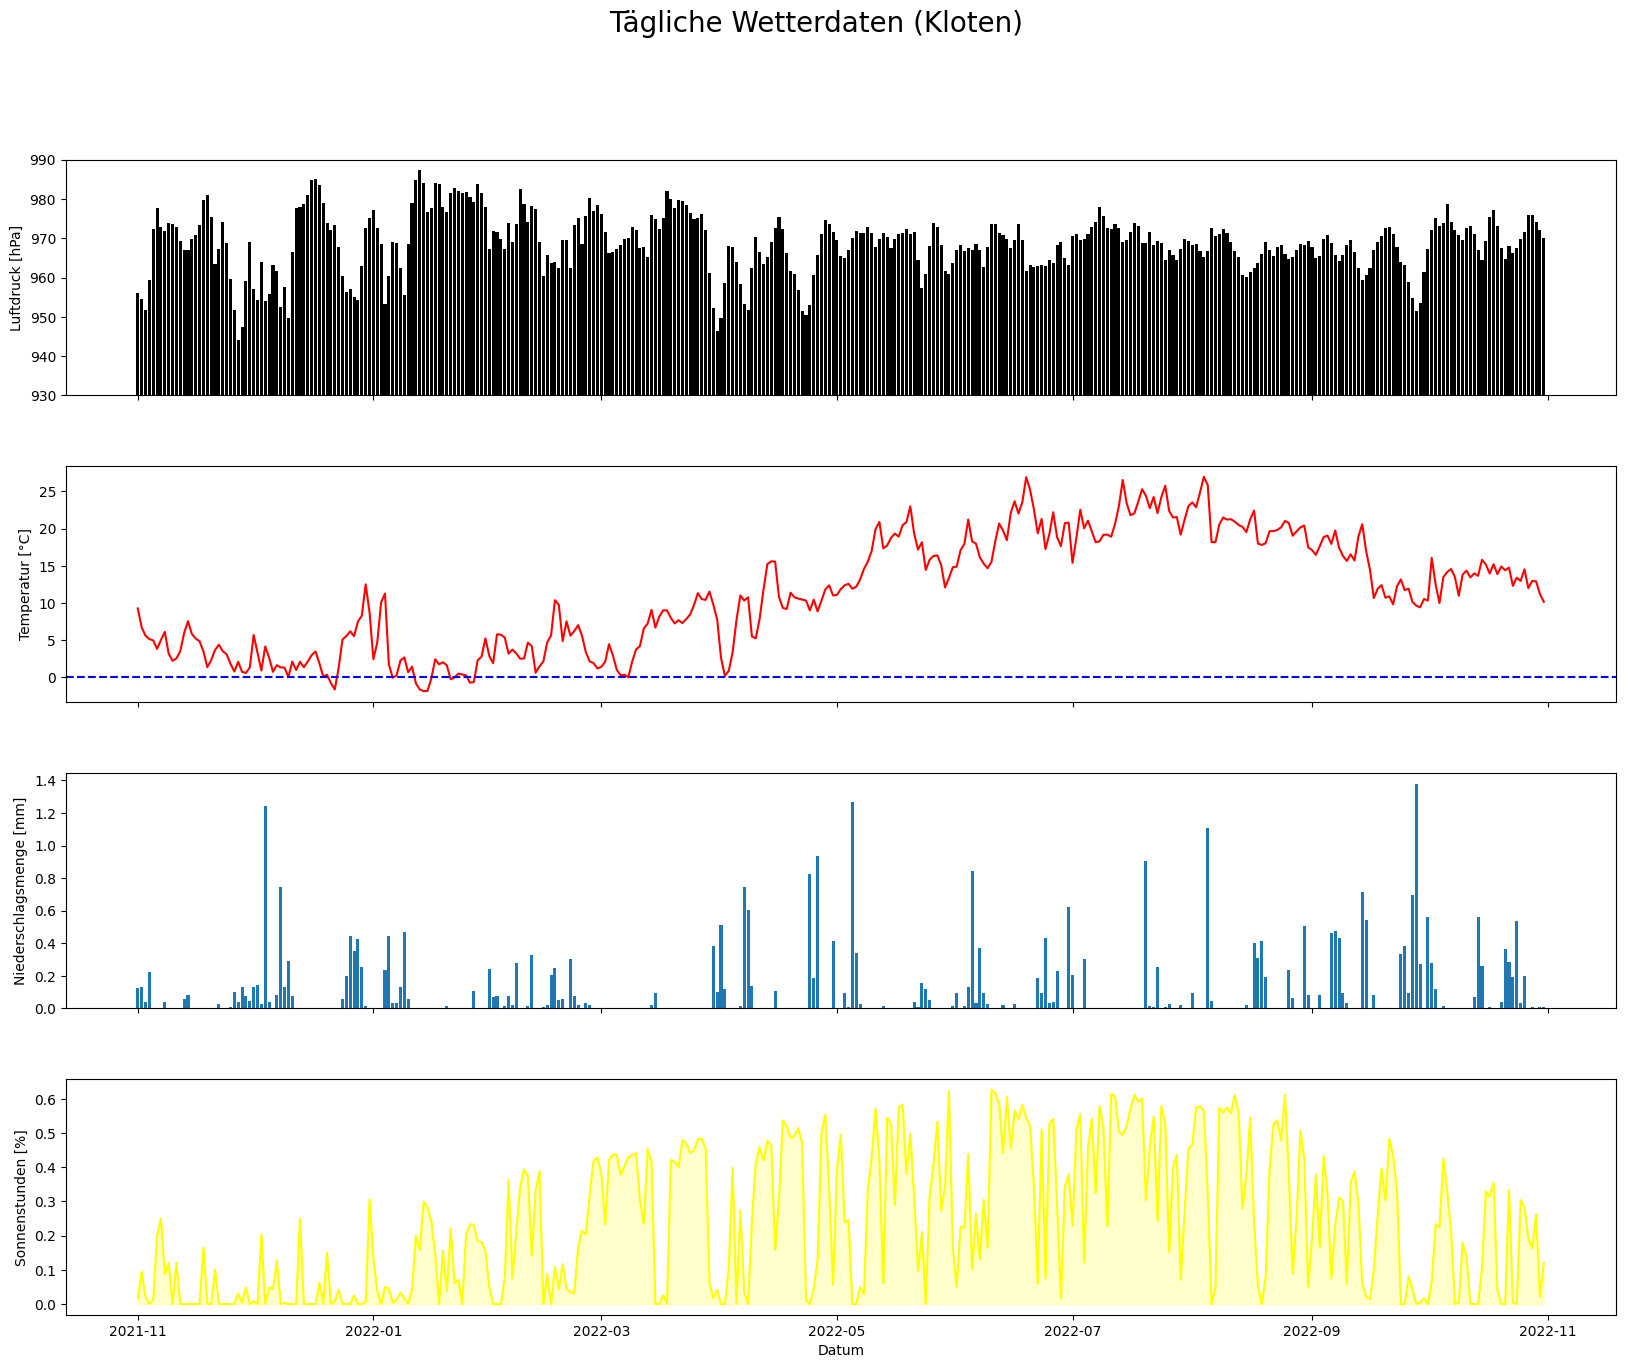

In [9]:
#Plot erstellen für die Tagesdurschnittsdaten
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,15))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.bar(date, daily_pressure, color='black')
ax1.set_ylim(930,990)
ax1.set_ylabel('Luftdruck [hPa]')


ax2.plot(date, daily_temp, color='red')
ax2.set_ylabel('Temperatur [°C]')
ax2.axhline(0, color='blue', linestyle='--')

ax3.bar(date, daily_rain)
ax3.set_ylabel('Niederschlagsmenge [mm]')

ax4.plot(date, daily_sunshine, color='yellow')
ax4.fill_between(date, daily_sunshine, 0, alpha=0.2, color='yellow')
ax4.set_ylabel('Sonnenstunden [%]')

plt.xlabel('Datum')
plt.suptitle('Tägliche Wetterdaten (Kloten)', fontsize=20)
plt.show()

Entscheidungen: 
- Zeitraum: 
Der ausgewählte Zeitraum erstreckt sich genau über ein Jahr. Dieser wurde gewählt, um eine ausreichende Datenmenge zu haben und ein jahreszeitliches Muster der Wetterdaten zu erfassen.
- Linien und Histogramme: 
    - Linien-Diagramme wurden verwendet, um den Verlauf von Temperatur und Sonnenstunden über die Zeit darzustellen. Der Vorteil von Linien liegt darin, dass kontinuierliche Daten gut visualisierbar sind. Zudem wurden die Sonnenstunden mit einer Flächenfüllung unter der Linie versehen, um den Bereich der sonnigen Stunden zu betonen.
    - Histogramme wurden für die Darstellung von Luftdruck und Niederschlagsmenge verwendet. Der Vorteil von Histogrammen liegt darin, dass diskrete Daten gut abbildbar sind. (Niederschlag z.B., ist keine kontinuierliche Größe, sondern immer mit einem Niederschlagsereignis verbunden. Zudem sind es aggregierten Werte, die den gesamten gefallenen Niederschlag in einem bestimmten Zeitraum wieder geben.)


## 4. Für die folgenden Punkte sollt ihr eine der Variablen auswählen.

#### Temperature it is!

In [32]:
#Nochmals interpolieren, damit wir eine Funktion haben mit nur den Temperaturdaten
f_cubic_temp = interp1d(time, temp, kind='cubic')

Bemerkung:

Da wir bei Punkt 2 über alle Messdaten interpoliert haben und somit eine gemeinsame Funktion hatten, wurde hier nochmals mit **nur** den Temperaturen interpoliert, um diese später besser in verschiedenen Funktionen verwenden zu können.

## 5. Vergleicht die ursprünglichen Daten mit den interpolierten Daten und zeigt eure Erkenntnisse auf. 
Wie wirken sich verschiedene Interpolationsmethoden auf den Wetterparameter Temperatur aus? 

1. Interpolierte Temperaturdaten über einen geeigneten Zeitraum visualiseren für den Vergleich.

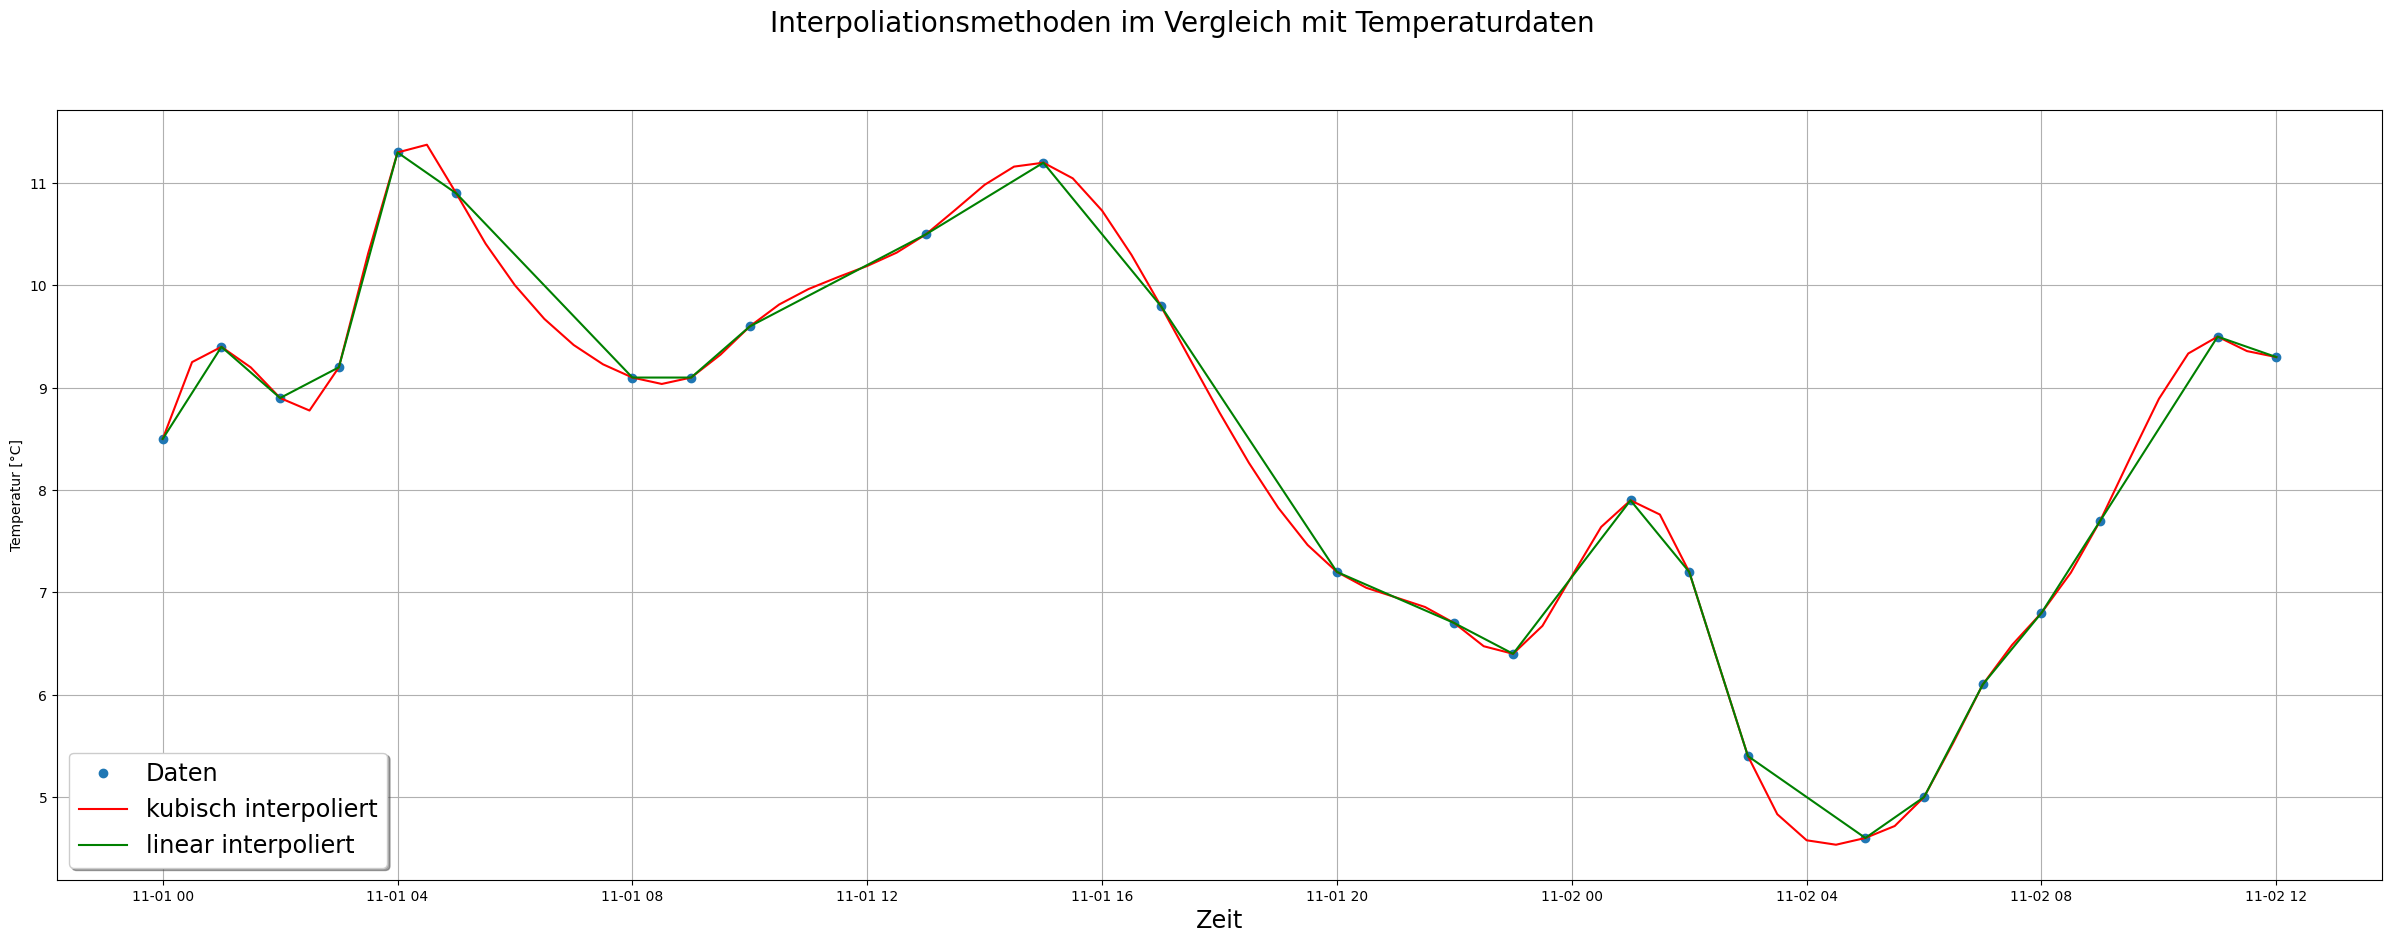

In [11]:
#Plot der unterschiedlich interpolierten Temperaturdaten erstellen
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(datetime_demo, temp[:25], 'o', label='Daten')
ax.plot(time_datetime_inter[0:max_demo], temp_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax.plot(time_datetime_inter[0:max_demo], temp_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax.set_ylabel('Temperatur [°C]')
ax.legend( loc='lower left', shadow=True, fontsize='xx-large')

plt.grid()
plt.xlabel('Zeit', fontsize='xx-large')

plt.suptitle('Interpoliationsmethoden im Vergleich mit Temperaturdaten', fontsize=20)
plt.show()

Entscheidung, basierend auf den Erkenntnissen aus Aufgabe 2 *Daten Interpolieren*:
 - Da die Temperaturdaten nicht-linear verlaufen, sondern viele Schwankungen (Höhen und Tiefen) aufweisen, ermöglicht die kubische Interpolation eine genauere Darstellung der Temperaturkurve. Im Gegensatz dazu liefert die lineare Interpolation eine geradlinige Verbindung zwischen den Datenpunkten und ist daher unpassend (ungenauer) um die Temperaturdaten zu interplieren.

Erkenntnis: 
 - Bei der Visualisierung der interpolierten Temperaturdaten über einen Zeitraum von 1.5 Tagen, ist uns aufgefallen, dass an gewissen Temperaturtief- und Hochpunkten aussergewöhlichen Aussschläge, erkennbar sind. Am 1.11.2021, nach 04:00 Uhr ist dies z.B. gut ersichtlich. Wir gehen davon aus, dass diese insensitivität gegenüber den Temperaturschwankungen mit der Anzahl der Messungen nach der Interpolation zusammenhänt. Für eine präzisere Abbildung der Temperaturkurve durch die Interpolation zu erreichen, hätten wir die Messungen in noch kürzeren Zeitintervallen durchführen müssen.

## 6. Berechnet Nullstellen bzw. Schnittpunkte mit einem Schwellenwert und überlegt euch, welche Aussagen ihr daraus ableiten könnt.
Wir ermitteln zuerst an wie vielen Tagen die Temperatur in Kloten unter Null Grad fällt und danach versuchen wir mit numerischen Mitteln Zeitpunkte im Januar zu bestimmen in welchen genau Null Grad ist.

### Minustemperaturen auslesen & ausgeben

In [26]:
#hier kommt ein kommentar
negative_crossings = np.where(temp_inter_cubic < 0)

In [27]:
zero_temp_days = time_datetime_inter[negative_crossings]

# Eindeutige Tage extrahieren
unique_days = np.unique(np.datetime_as_string(zero_temp_days, unit='D'))
unique_days

In [14]:
print('Anzahltage mit Minustemperaturen:', len(unique_days))
print('Letzter Tag im Winter/Frühling 21/22 in dem die Temperatur nochmals unter Null fiel:' , unique_days[-1])

Anzahltage mit Minustemperaturen: 86
Letzter Tag im Winter/Frühling 21/22 in dem die Temperatur nochmals unter Null fiel: 2022-04-11


### Temperatur nahe 0 °C finden mit numerischen Mittel

1. Im ersten Teil des Codes werden die Start- und Endzeitpunkte für den betrachteten Zeitraum festgelegt. In diesem Fall wird der Zeitraum vom 1. Januar 2022 bis zum 14. Januar 2022 gewählt, da viele Nullstellen erwartet werden.
2. Um mögliche Nullstellen mit dem Auge zu erkennen wird anschließend wird ein Plot erstellt, der die Temperaturwerte im definierten Zeitraum zeigt.
3. Nachdem der Plot erstellt wurde, sollen die Nullstellen der Funktion f_cubic_temp im betrachteten Zeitraum ermittelt werden. Hierzu werden das Newtonverfahren und das Bisektionsverfahren verwendet. Das Newtonverfahren wird durch die Funktion optimize.newton aufgerufen und erhält als Startwert den Zeitpunkt des 1. Januar 2022. Das Bisektionsverfahren wird durch die Funktion optimize.bisect zweimal aufgerufen und erhält als Intervallgrenzen verschiedene Zeitpunkte im Januar 2022.
4. Die gefundenen Nullstellen werden in den Datentyp datetime64[m] konvertiert, um sie in dem Plot verwenden zu können. Dies erfolgt für alle drei Nullstellen zero1_datetime, zero2_datetime und zero3_datetime.
5. Im letzten Teil des Codes wird ein neuer Plot erstellt, der die Temperaturwerte im betrachteten Zeitraum sowie die gefundenen Nullstellen zeigt.

In [15]:
#Zeitraum mit vielen Nullstellen
january_start = np.datetime64('2022-01-01T00:00').astype(float)
january_start_index = int(np.where(time_new == january_start)[0])

january_end = np.datetime64('2022-01-14T23:30').astype(float)
january_end_index = int(np.where(time_new == january_end)[0])

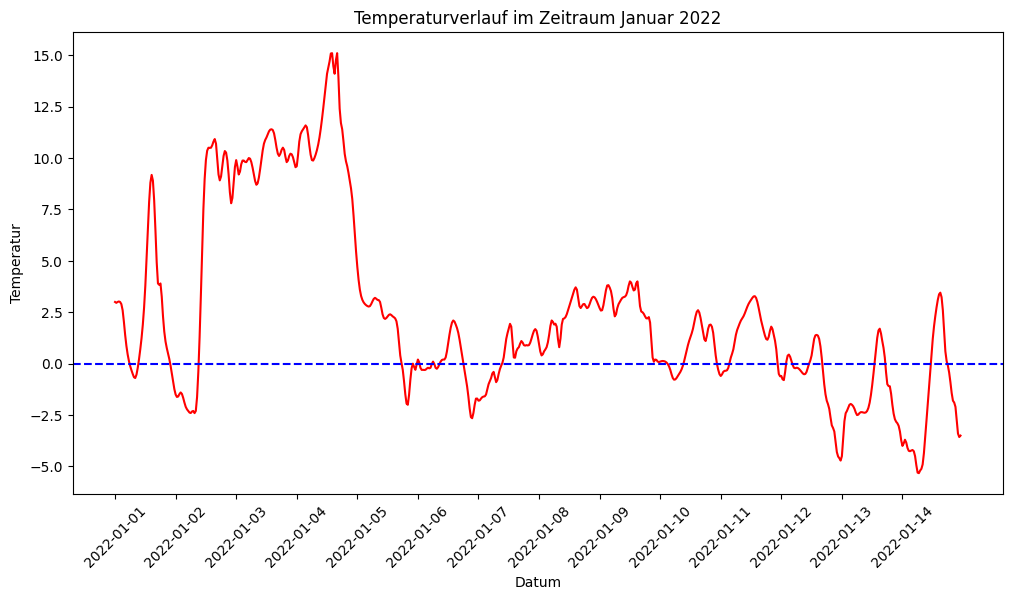

In [16]:
# Plot der Funktion
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_datetime_inter[january_start_index:january_end_index], temp_inter_cubic[january_start_index:january_end_index], color='red')
ax.axhline(0, color='blue', linestyle='--')

ax.set_xlabel('Datum')
x_ticks = np.arange(time_datetime_inter[january_start_index], time_datetime_inter[january_end_index], np.timedelta64(24, 'h'))
ax.set_xticks(x_ticks)

plt.xticks(rotation = 45)
plt.ylabel('Temperatur')
plt.title('Temperaturverlauf im Zeitraum Januar 2022')

plt.show()

In [17]:
#Nullstellen ermitteln mit dem Newtonverfahren
zero1 = optimize.newton(f_cubic_temp, np.datetime64('2022-01-01T00:00').astype(float)) 

#Nullstellen ermitteln mit dem Bisektionsverfahren
zero2 = optimize.bisect(f_cubic_temp, np.datetime64('2022-01-02T00:00').astype(float), np.datetime64('2022-01-03T00:00').astype(float))
zero3 = optimize.bisect(f_cubic_temp, np.datetime64('2022-01-01T12:00').astype(float), np.datetime64('2022-01-02T00:00').astype(float))

In [18]:
#Nullstellen wieder der x-Achse für den plot anpassen
zero1_datetime = zero1.astype("datetime64[m]")
zero2_datetime = np.float64(zero2).astype("datetime64[m]") #bisektion verfahren gibt den typ float zurück (und nicht typ np.float64) und dieser lässt sich nicht direkt in dateteim64 umwandeln
zero3_datetime = np.float64(zero3).astype("datetime64[m]")

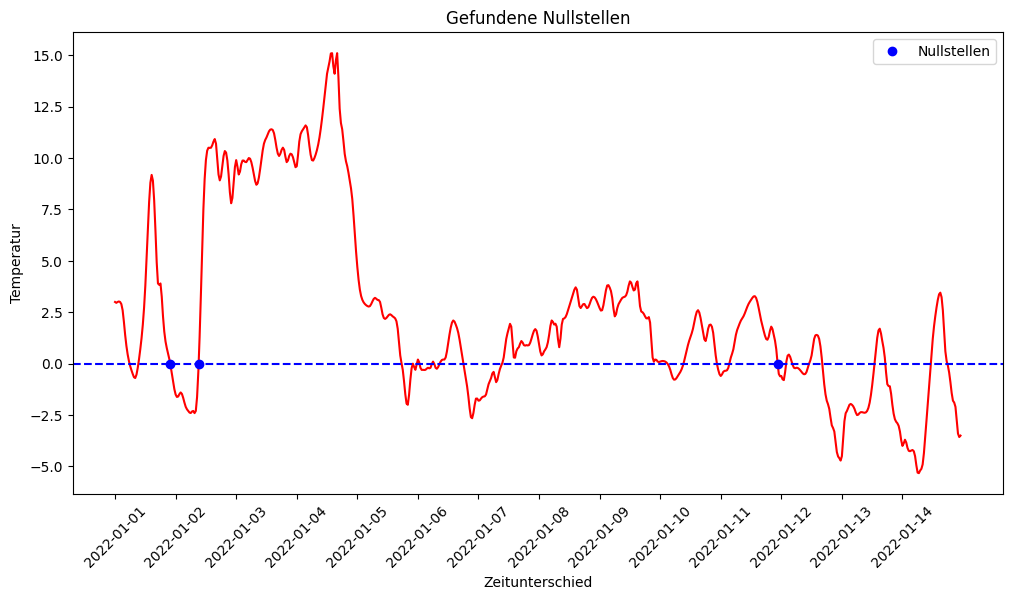

In [19]:
#Gefundene Nullstellen ploten
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_datetime_inter[january_start_index:january_end_index], temp_inter_cubic[january_start_index:january_end_index], color='red')

ax.plot([zero1_datetime, zero4_datetime, zero5_datetime], [f_cubic_temp(zero1),f_cubic_temp(zero2),f_cubic_temp(zero3)], "ob", label="Nullstellen")
ax.axhline(0, color='blue', linestyle='--')

ax.set_xlabel('Zeitunterschied')
ax.set_ylabel('Temperatur')
ax.set_title('Gefundene Nullstellen')

# Einen Tick pro Tag anzeigen
x_ticks = np.arange(time_datetime_inter[january_start_index], time_datetime_inter[january_end_index], np.timedelta64(24, 'h'))
ax.set_xticks(x_ticks)

plt.xticks(rotation=45)

ax.legend()
plt.show()

Erkenntnise:
- In der Newton-Methode hätte man noch mit dem Toleranzwert und maximale Anzahl Wiederholung spielen können, um auf ein noch genaueres Ergebnis zu kommen. Das Ergebnis ist aber auch so genau genug für unsere Zwecke.
- Mit der Intention eine Nullstelle am 01.01.2022 zu finden, wurde die Newton-Methode angwendet, schlussendlich wurde eine Nullstelle 10 Tage später gefunden.
- Durch die Interpolation mit `time` wurde der Visualisierungsprozess anspruchsvoller, da wir das Datumsformat mehrmals anpassen mussten. Diese Anpassungen waren jedoch von Bedeutung für die Darstellung der Zeitachse, da sonst die X-Werte der Funktion nicht lesbar gewesen wären.
- Auf das Loopen über Schwellenwerte wurde verzichtet (um möglichst viele Nullstellen zu finden), da wir unsere Aussage schon mit einem einfachen auslesen der Y-Werte treffen konnten. 

## 7. Mithilfe der Ableitung soll nach grossen Änderungen in den Daten gesucht werden. 
Hier wird der Tag mit der kleinsten und grössten Steigung der Temperaturen mit der np.gradient-Funktion ermittelt.

1. Die Steigung bzw. die Gradienten der Temperaturwerte werden in dem Array `temp_inter_cubic` berechnet.
2. Der kleinster und grösster Wert werden ausgelesen und ausgegeben.

In [20]:
#Steigung der Temperaturen berechnen
df = np.gradient(temp_inter_cubic)

#Index der kleinste steigung bzw. grösste Abnahme auslese``
i_min = np.argmin(df)
#Index der grössten steigung auslesen
i_max = np.argmax(df) 

print("maximale Abnahme:",(df[i_min]), "am", (time_datetime_inter[i_min])) 
print("maximale Zunahme:",(df[i_max]), "am", (time_datetime_inter[i_max]))

maximale Abnahme: -3.8999999999999986 am 2022-08-05T17:30
maximale Zunahme: 2.3 am 2022-02-24T09:30


Bemerkung:

Die Funktion np.gradient aus dem NumPy-Paket wird verwendet, um die numerische Ableitung der Temperaturwerte zu berechnen. Sie berechnet die Änderungsrate (Steigung) zwischen aufeinanderfolgenden Werten im Array und gibt ein neues Array zurück, das die berechneten Steigungswerte enthält.

Erkenntnis: 
Die np.gradient berechnet auch für den ersten und letzten Wert die Steigung.

## 8. Benutze die Integration, um gewisse Durchschnittswerte über einen definierten Zeitraum zu berechnen.
In diesem Abschnitt werden die Durschnittstemperaturen über den Sommer aufzeigt mit Hilfe der integrate.quad-Funktion aus dem SciPy-Paket.

1. Zunächst werden die Start- und Enddaten des astronomischen Sommers auf der Nordhalbkugel definiert.

2. Die Funktion mean_func_extended berechnet den durchschnittlichen Wert einer Funktion func über das Intervall von a bis b durch Aufteilung des Intervalls in num_subintervals Untereinheiten. Sie verwendet die Funktion integrate.quad aus dem Modul scipy.integrate, um das Integral der Funktion über jedes Untereinheit-Intervall zu berechnen.

3. Die Funktion mean_func_extended wird verwendet, um den Durchschnitt der Temperatur über den Sommer zu berechnen. Der Funktionsname f_cubic_temp wird als Argument übergeben, zusammen mit den Start- und Enddaten des Sommers und der Anzahl der Untereintervalle (in diesem Fall 80).

4. Ein Diagramm wird erstellt, das die Temperatur während des Sommers darstellt. Die Funktion ax.plot wird verwendet, um die Temperaturdaten zwischen den Start- und Endindizes zu plotten. Eine horizontale Linie wird hinzugefügt, die den berechneten Durchschnitt der Temperatur darstellt. Das Diagramm enthält auch Achsentitel und eine Legende.

In [21]:
#Beginn des astronomischen Sommers auf der Nordhalbkugel 

#Beginn des astronomischen Sommers auf der Nordhalbkugel wird als Float-Wert abgespeichert, da unsere X-Achse unser interpolationsfunktion f_cubic_temp auch Zeitwerte als float hat.
summer_start = np.datetime64('2022-06-21T00:00').astype(float)
summer_start_index = int(np.where(time_new == summer_start)[0])

#Ende des astronomischen Sommers auf der Nordhalbkugel
summer_end = np.datetime64('2022-09-22T00:00').astype(float)
summer_end_index = int(np.where(time_new == summer_end)[0])

In [22]:
#Durschnitt berechnen anhand eines Funktionsabschnitts unterteilt in intervalle
def mean_func_extended(func, a, b, num_subintervals):
    interval_width = (b - a) / num_subintervals
    integral_sum = 0.0

    for i in range(num_subintervals):
        subinterval_a = a + i * interval_width
        subinterval_b = subinterval_a + interval_width
        integral, error = integrate.quad(func, subinterval_a, subinterval_b)
        integral_sum += integral

    return integral_sum / (b - a)

Erkenntis:

Dazu verwenden wir die scipy.integrate Funktion "quad". Für die Genauigkeit sind Subintervalle nötig, sonst gibt die Funktion "quad" eine Fehlermeldung aus. Nach dem Runden wäre das Ergebnis auch ohne Subintervalle korrekt, jedoch nehmen wir die wenige sekunden in kauf aufgrund ästhetischen Gründen (keine Fehlermeldung im Notebook).

In [23]:
#Durschnittstemperatur berechnung in den Sommertagen
mean_temp_extended = mean_func_extended(f_cubic_temp, summer_start, summer_end, 80) #80 Subintervalle, damit keine Fehlermeldung erscheint

#Durschnittstemperatur auf eine Nachkommastelle runden
mean_temp_rounded = round(mean_temp_extended, 1)

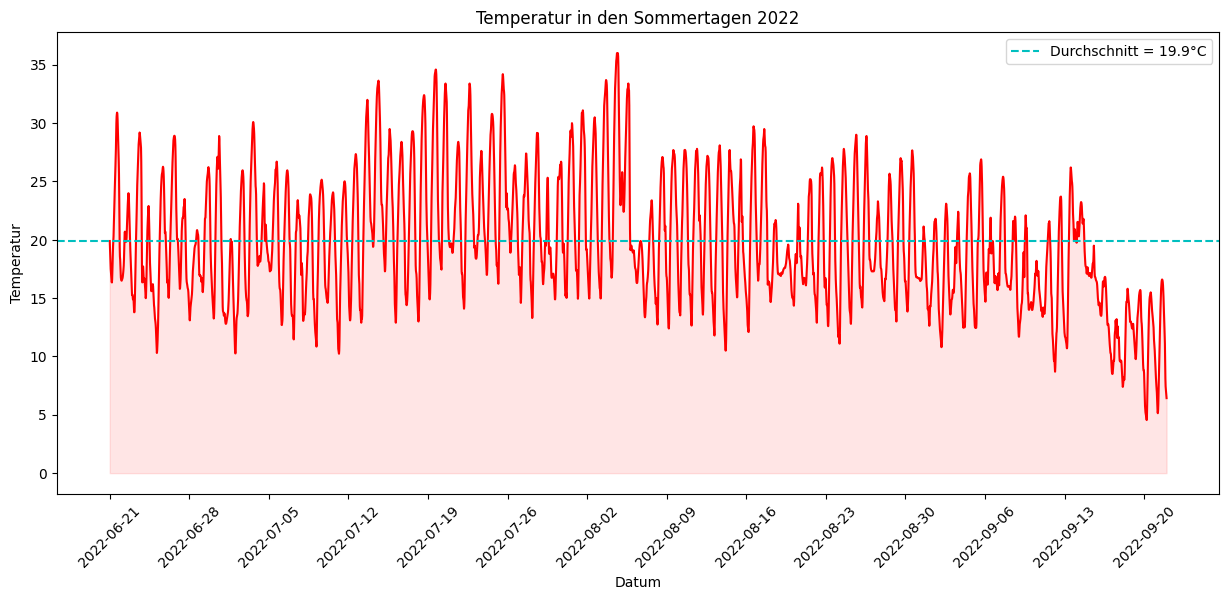

In [29]:
#Plot erstellen der Temperatur in den Sommertagen mit dem Durschnitt
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(time_datetime_inter[summer_start_index:summer_end_index], temp_inter_cubic[summer_start_index:summer_end_index], color='red')

ax.axhline(y=mean_temp_extended, color='c', linestyle='--', label='Durchschnitt = '+ str(mean_temp_rounded) + '°C')

ax.set_xlabel('Datum')
ax.set_ylabel('Temperatur')
ax.set_title('Temperatur in den Sommertagen 2022')

# Fill-Bereich zwischen den Kurven und der x-Achse
ax.fill_between(time_datetime_inter[summer_start_index:summer_end_index], temp_inter_cubic[summer_start_index:summer_end_index], 0, alpha=0.1, color='red')

# Einen Tick pro Tag anzeigen
x_ticks = np.arange(time_datetime_inter[summer_start_index], time_datetime_inter[summer_end_index], np.timedelta64(168, 'h'))
ax.set_xticks(x_ticks)

plt.xticks(rotation=45)

ax.legend()
plt.show()

In [25]:
print("Die Durschnittstemperatur durch den Sommer betrug", mean_temp_rounded, "°C")

Die Durschnittstemperatur durch den Sommer betrug 19.9 °C


Bemerkung:

Es wurde die integrate.quad Funktion verwendet, da diese Funktion in der Regel ein genaueres Ergebnis liefert als integrate.trapezoid. Die Berechnungsdauer dauert dafür ein bisschen länger.

## Zusammenfassung eurer wichtigsten Ergebnisse und Erkenntnisse

Im Rahmen dieses Projekts hatten wir die Möglichkeit, eine eingehende Analyse der Wetterdaten von Kloten durchzuführen und dabei die numerischen Grundlagen der Data Science, die uns im Fach vermittelt wurden, praktisch anzuwenden und umzusetzen. 

Ergebnisse:
Die Entscheidung fiel auf die kubische Interpolation für die Parameter Temperatur und Luftdruck, da diese eine genauere Darstellung der Kurven ermöglichten. Für Sonnenstunden und Niederschlagsmenge wurde die lineare Interpolation verwendet. Die Visualisierung der interpolierten Daten über einen ausgewählten Zeitraum ermöglichte einen Vergleich mit den ursprünglichen Daten. 

Es wurde festgestellt, dass die kubische Interpolation genaue Ergebnisse für die Temperatur lieferte, während die lineare Interpolation für Sonnenstunden und Niederschlagsmenge ausreichend war. Es wurden jedoch Probleme bei der Genauigkeit der Temperaturinterpolation festgestellt, insbesondere bei extremen Temperaturschwankungen. 

Die Nullstellen der Temperatur wurden numerisch berechnet, um Tage mit Temperaturen unter null Grad zu identifizieren. Dabei wurden sowohl das Newton-Verfahren als auch das Bisektionsverfahren verwendet. Es wurden auch große Änderungen in den Temperaturdaten mithilfe der Ableitung ermittelt. 

Die Integration wurde genutzt, um Durchschnittswerte für bestimmte Zeiträume zu berechnen. Insbesondere wurde der Durchschnitt der Temperatur über den Sommer ermittelt. 

Gewonnene Erkenntnise:

- Es gibt immer mehrere Wege um an ein gewünschtes Ergebnis zu kommen. Man muss immer abwägen zwischen genauigkeit, geschwindigkeit und aufwand der Umsetzung.
- Alle Nullstellen können nur durch die interpolierte Werte gefunden werden. Zuerst dachten wir, wir können einfach unser Array mit den Y-Werten bzw. Temperaturdaten absuchen, aber da hat es logischerweise Lücken in den Daten und Nullstellen können "überhüpft" werden.
- Zeitdaten sind schwer zu handeln. Es werden immer wieder verschiedene Formattierungen benötigt umd Funktionen zu benutzen oder um die Daten verständlicher zu visualisieren.
- 

In diesem Dokument wurde eine Analyse der Wetterdaten für Kloten durchgeführt. Die Daten wurden importiert und vorbereitet, indem sie transponiert und in geeignete Datentypen umgewandelt wurden. Da einige Datenpunkte fehlten, wurden verschiedene Interpolationsmethoden angewendet, um diese Lücken zu füllen. 



Insgesamt ergaben sich wichtige Erkenntnisse über die Daten und deren Interpretation. Es wurden jedoch auch einige Probleme festgestellt, insbesondere in Bezug auf die Genauigkeit der Interpolation bei extremen Temperaturschwankungen. Diese Ergebnisse liefern eine solide Grundlage für weitere Untersuchungen und Analysen der Wetterdaten von Kloten. 